In [1]:
# In this notebook we investigate the punch and fill 

import numpy as np
import math
import time
import scipy.signal
from   astropy.convolution import convolve, Kernel
from   nexusformat.nexus import *
import os
import matplotlib.pyplot as plt
from time import perf_counter 

def _round_up_to_odd_integer(value):
    i = int(math.ceil(value))
    if i % 2 == 0:
        return i + 1
    else:
        return i

class Gaussian3DKernel(Kernel):
    #
    _separable = True
    _is_bool   = False
    #
    def __init__(self, stddev, **kwargs):
        x                  = np.linspace(-15., 15., 17)
        y                  = np.linspace(-15., 15., 17)
        z                  = np.linspace(-15., 15., 17)
        X,Y,Z              = np.meshgrid(x,y,z)
        array              = np.exp(-(X**2+Y**2+Z**2)/(2*stddev**2))
        self._default_size = _round_up_to_odd_integer(8 * stddev)
        super(Gaussian3DKernel, self).__init__(array)
        self.normalize()
        self._truncation   = np.abs(1. - self._array.sum())

gkernal = Gaussian3DKernel(2)

from astropy.convolution import Gaussian2DKernel
gaussian_2D_kernel = Gaussian2DKernel(10)

In [2]:
gkernal.array

array([[[1.18863117e-38, 8.66618836e-36, 2.62364456e-33, ...,
         2.62364456e-33, 8.66618836e-36, 1.18863117e-38],
        [8.66618836e-36, 6.31842934e-33, 1.91287243e-30, ...,
         1.91287243e-30, 6.31842934e-33, 8.66618836e-36],
        [2.62364456e-33, 1.91287243e-30, 5.79112423e-28, ...,
         5.79112423e-28, 1.91287243e-30, 2.62364456e-33],
        ...,
        [2.62364456e-33, 1.91287243e-30, 5.79112423e-28, ...,
         5.79112423e-28, 1.91287243e-30, 2.62364456e-33],
        [8.66618836e-36, 6.31842934e-33, 1.91287243e-30, ...,
         1.91287243e-30, 6.31842934e-33, 8.66618836e-36],
        [1.18863117e-38, 8.66618836e-36, 2.62364456e-33, ...,
         2.62364456e-33, 8.66618836e-36, 1.18863117e-38]],

       [[8.66618836e-36, 6.31842934e-33, 1.91287243e-30, ...,
         1.91287243e-30, 6.31842934e-33, 8.66618836e-36],
        [6.31842934e-33, 4.60670224e-30, 1.39465573e-27, ...,
         1.39465573e-27, 4.60670224e-30, 6.31842934e-33],
        [1.91287243e-30, 

In [3]:
gaussian_2D_kernel.array

array([[1.79105293e-10, 2.65861066e-10, 3.90713230e-10, ...,
        3.90713230e-10, 2.65861066e-10, 1.79105293e-10],
       [2.65861066e-10, 3.94639963e-10, 5.79968542e-10, ...,
        5.79968542e-10, 3.94639963e-10, 2.65861066e-10],
       [3.90713230e-10, 5.79968542e-10, 8.52330075e-10, ...,
        8.52330075e-10, 5.79968542e-10, 3.90713230e-10],
       ...,
       [3.90713230e-10, 5.79968542e-10, 8.52330075e-10, ...,
        8.52330075e-10, 5.79968542e-10, 3.90713230e-10],
       [2.65861066e-10, 3.94639963e-10, 5.79968542e-10, ...,
        5.79968542e-10, 3.94639963e-10, 2.65861066e-10],
       [1.79105293e-10, 2.65861066e-10, 3.90713230e-10, ...,
        3.90713230e-10, 2.65861066e-10, 1.79105293e-10]])

In [4]:
N = 101 #641
halfN = 50 #300
data = np.random.randn(N,N,N)

In [5]:

t1_start = perf_counter() 
vvals = convolve(data,gkernal)
t1_stop = perf_counter() 
print("Elapsed time (in seconds):", t1_stop-t1_start) 


Elapsed time (in seconds): 4.749309809


In [6]:
from julia import Julia
julia = Julia(compiled_modules=False)

from julia import Main

julia.eval("@eval Main import Base.MainInclude: include")

Main.include("kernelconv.jl")

<PyCall.jlwrap nanconv>

In [7]:
julia.VERSION

<PyCall.jlwrap 1.4.0>

In [8]:

t1_start = perf_counter() 
result = julia.clip3conv(data,gkernal.array)
t1_stop = perf_counter() 

print("Elapsed time (in seconds):", t1_stop-t1_start) 

Elapsed time (in seconds): 3.376157018999997


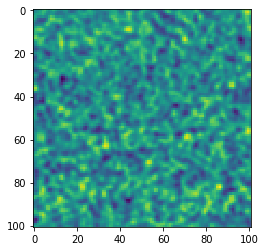

In [9]:
plt.imshow(vvals[:,:,0])

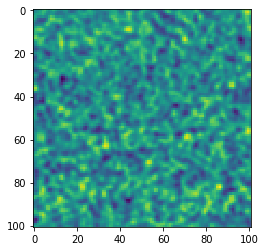

In [10]:
plt.imshow(result[:,:,0]) #[8:N+8,8:N+8,8]

In [11]:
result - vvals

array([[[ 0.00000000e+00, -2.49800181e-16, -2.77555756e-17, ...,
         -1.77809156e-17, -6.24500451e-17,  4.16333634e-17],
        [ 4.85722573e-17, -2.77555756e-17,  6.93889390e-17, ...,
         -1.38777878e-17,  9.71445147e-17,  2.77555756e-17],
        [-1.73472348e-18, -2.42861287e-17,  6.93889390e-17, ...,
          2.08166817e-17, -2.77555756e-17, -5.55111512e-17],
        ...,
        [-4.71844785e-16, -2.77555756e-17,  6.85215773e-17, ...,
         -2.49800181e-16,  2.77555756e-17, -1.38777878e-17],
        [ 2.77555756e-16, -2.49800181e-16, -6.93889390e-18, ...,
         -2.77555756e-17,  1.94289029e-16, -6.93889390e-17],
        [ 2.77555756e-17, -2.49800181e-16, -1.38777878e-17, ...,
          2.47198095e-17, -1.04083409e-17, -2.08166817e-17]],

       [[ 4.16333634e-17, -5.55111512e-17, -2.63677968e-16, ...,
          4.16333634e-17, -1.94289029e-16, -1.04083409e-17],
        [ 4.85722573e-17,  0.00000000e+00,  1.43982049e-16, ...,
         -3.33066907e-16, -1.94289029e

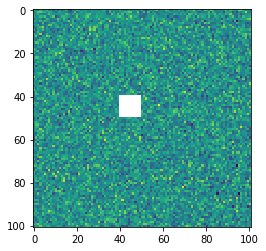

In [12]:

# Our convolution code has to deal with NaNs properly
nan_locs = np.zeros((N,N,N))
nan_locs[halfN-10:halfN,halfN-10:halfN,halfN-10:halfN] = 1

data2 = np.copy(data)
data2[halfN-10:halfN,halfN-10:halfN,halfN-10:halfN] = np.nan
plt.imshow(data2[:,:,halfN-3])

In [13]:
t1_start = perf_counter() 
vvals = convolve(data2,gkernal)
t1_stop = perf_counter() 

print("Python time (in seconds):", t1_stop-t1_start)


Python time (in seconds): 4.867221533999999


In [14]:

t1_start = perf_counter() 
result = julia.nanconv(data, gkernal.array, nan_locs)
t1_stop = perf_counter() 

print("Julia time (in seconds):", t1_stop-t1_start)

Julia time (in seconds): 2.5478222079999995


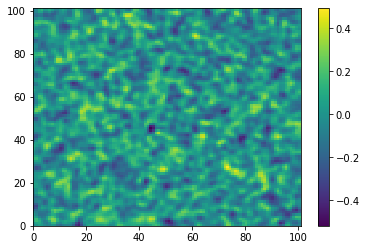

In [15]:
plt.pcolor(vvals[:,:,halfN-3])
plt.colorbar()

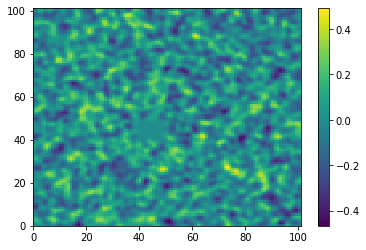

In [16]:
plt.pcolor(result[:,:,halfN-3]) # [8:N+8,8:N+8,halfN-3+8]
plt.colorbar()

In [18]:
result[halfN-10:halfN,halfN-10:halfN,halfN-10:halfN] - vvals[halfN-10:halfN,halfN-10:halfN,halfN-10:halfN]
# errors here seem to be larger than machine precision

array([[[-3.65875529e-02, -9.93384473e-02, -1.64120624e-01, ...,
         -3.89583542e-03,  3.79875053e-02,  4.55597672e-02],
        [ 2.27349460e-02, -5.09782523e-02, -1.80400620e-01, ...,
          2.96002166e-02,  5.27057769e-03,  1.51694660e-02],
        [ 6.35607393e-02,  7.88243190e-02,  1.78741862e-02, ...,
         -2.63866142e-02, -3.58692580e-02,  3.12679984e-02],
        ...,
        [-3.16254871e-02, -4.10181905e-02, -2.60649821e-03, ...,
          1.27062442e-02,  8.38080497e-02,  3.64814782e-02],
        [ 1.40642759e-03,  4.17718203e-02,  5.60438916e-02, ...,
          1.90098854e-02,  7.89254023e-02,  4.74046261e-02],
        [ 6.30955875e-02,  1.09462514e-01,  1.37340463e-01, ...,
          5.05405374e-03,  6.12606475e-04,  3.82577898e-03]],

       [[-1.43180499e-01, -2.62208322e-01, -2.65300503e-01, ...,
         -8.65691786e-03,  1.52783078e-02,  2.07581834e-02],
        [-2.71460907e-02, -1.86152442e-01, -3.17132669e-01, ...,
          1.02308771e-02,  4.05873838e